<h1>Image Classification of Road Traffic Signs<h1>

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'1.15.2'

In [2]:
#upload and unzip data file
import zipfile
with zipfile.ZipFile('./trafficsigns_dataset.zip', 'r') as zip_ref:
 zip_ref.extractall('./')

# Data Frame #

Creating a data frame taking shape category into consideration . 

In [3]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('trafficsigns_dataset/*/*/*.png', recursive=True): #assuming gif
    shape = filepath.split("/")[1]
    label = filepath.split("/")[2]
    image_list.append((filepath, label, shape))
    
# Create a data frame
shape_data = pd.DataFrame(data=image_list, columns=['image_path', 'label', 'shape'])

# Understand Data and Preprocessing #
    
Random generating images to get idea about the Data

In [4]:
#understand shape of dataframe
shape_data = shape_data[['image_path','shape']]
shape_data.head()

,image_path,shape
0,trafficsigns_dataset/diamond/rightofway/00937_...,diamond
1,trafficsigns_dataset/diamond/rightofway/01588_...,diamond
2,trafficsigns_dataset/diamond/rightofway/01935_...,diamond
3,trafficsigns_dataset/diamond/rightofway/00928_...,diamond
4,trafficsigns_dataset/diamond/rightofway/01002_...,diamond


In [5]:
#grouping
shape_data_group= shape_data.groupby(["shape"])
shape_data_group_plot= shape_data_group.count()

,image_path
shape,
diamond,282
hex,43
round,1760
square,688
triangle,926


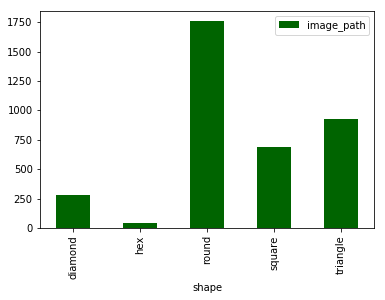

In [6]:
#plotting bar chart
shape_data_group_plot.plot(kind='bar',color=('darkgreen'))
shape_data_group.count()

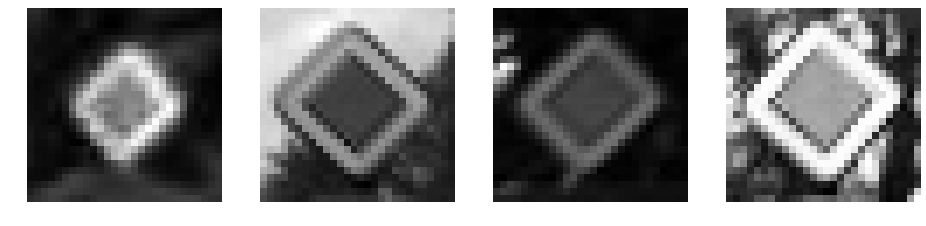

In [7]:
r_inx = np.random.choice(100, 4)
rand_data = shape_data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

# Splitting data by K means clustering #

In [8]:

from sklearn.model_selection import train_test_split

train_shapes, test_shapes = train_test_split(shape_data,test_size = 0.2)
training_data, validation_data = train_test_split(train_shapes,test_size = 0.2)


# Generate two data frames for training and validation #
print('Train size: {}, Test size: {}'.format(training_data.shape[0], validation_data.shape[0] ) ) 
N_train_images = training_data.shape[0]
N_val_images = validation_data.shape[0]

Train size: 2367, Test size: 592


# Multi Layer Perception

we will use MLP to predict the shape of the traffic road sign.
The road signs are present in 5 shapes -> Diamond, Hex, round, square and triangle.
We have 28x28 features and four classes, so the input layer must have 784 units, and the output layer must have 5 units. We will use one hidden layers and we'll give it 64 neurons.

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy

# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64)(x)
h = Activation('sigmoid')(h)

# Output layer
out_ = Dense(5)(h)
out_ = Activation('softmax')(out_)

# Define model
model_orig = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_orig.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


model_orig.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
______________________________________________

# Loading Function #
we are using rmsprop and categorical_crossentropy because there are more than two categories in the output variable.since dataset is complicated we will be loading them in batches, and batch size is chosen as 16.
The loading function converts channels into 3-channel images.Data normalization is done to bring it in pixel [0-1] value

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_data,
    directory='./', 
    x_col="image_path", 
    y_col="shape", 
    target_size=(28, 28), 
    batch_size=batch_size, 
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_data,
    directory='./', 
    x_col="image_path", 
    y_col="shape", 
    target_size=(28, 28), 
    batch_size=batch_size, 
    class_mode='categorical')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=test_shapes,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        shuffle = False,
        batch_size=batch_size,
        class_mode='categorical')

Found 2367 validated image filenames belonging to 5 classes.
Found 592 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [11]:
batch_size = 16

<h2>Accuracy and Loss Function<h2>

In [12]:
def calculate_losses(model_, data_generator_, N_images, batch_size_): 
    loss_hold = []
    acc_hold = []
    batches = 0
    for x,y in data_generator_:
        loss,acc = model_.evaluate(x, y, verbose=0) 
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because 
            # the generator loops indefinitely
            break
        
    return np.mean(loss_hold), np.mean(acc_hold)

<h2> Training model <h2>

In [13]:
#function to train a model train the model
def train_model(model_, num_epoch=100, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [14]:
#training the model
res = train_model(model_orig, num_epoch=100, verbose=1)

Training epoch 0: Loss = 1.063613772392273, Accuracy = 0.5953266024589539
Validation epoch 0: Loss = 0.8252962747135678, Accuracy = 0.7314189076423645
Training epoch 1: Loss = 0.6869167685508728, Accuracy = 0.7764639854431152
Validation epoch 1: Loss = 0.596904867404216, Accuracy = 0.7989864945411682
Training epoch 2: Loss = 0.5124861001968384, Accuracy = 0.8547297120094299
Validation epoch 2: Loss = 0.47460384948833567, Accuracy = 0.8665540814399719
Training epoch 3: Loss = 0.41580334305763245, Accuracy = 0.8888513445854187
Validation epoch 3: Loss = 0.404748470597976, Accuracy = 0.8800675868988037
Training epoch 4: Loss = 0.3487528860569, Accuracy = 0.903476893901825
Validation epoch 4: Loss = 0.36805090872017115, Accuracy = 0.8885135054588318
Training epoch 5: Loss = 0.3035115599632263, Accuracy = 0.9226914644241333
Validation epoch 5: Loss = 0.34261586235181707, Accuracy = 0.8918918967247009
Training epoch 6: Loss = 0.2683315873146057, Accuracy = 0.9309543967247009
Validation epoch

Training epoch 53: Loss = 0.029639936983585358, Accuracy = 0.998099684715271
Validation epoch 53: Loss = 0.20342032868113066, Accuracy = 0.9358108043670654
Training epoch 54: Loss = 0.028790036216378212, Accuracy = 0.9972550868988037
Validation epoch 54: Loss = 0.2015790098120232, Accuracy = 0.9324324131011963
Training epoch 55: Loss = 0.029152683913707733, Accuracy = 0.9970439076423645
Validation epoch 55: Loss = 0.20117850073084637, Accuracy = 0.9324324131011963
Training epoch 56: Loss = 0.026923660188913345, Accuracy = 0.998099684715271
Validation epoch 56: Loss = 0.20264377042248444, Accuracy = 0.9324324131011963
Training epoch 57: Loss = 0.026482077315449715, Accuracy = 0.9980714917182922
Validation epoch 57: Loss = 0.21417632980926618, Accuracy = 0.9341216087341309
Training epoch 58: Loss = 0.025829728692770004, Accuracy = 0.9983108043670654
Validation epoch 58: Loss = 0.19827451291368217, Accuracy = 0.9307432174682617
Training epoch 59: Loss = 0.025408748537302017, Accuracy = 0.

In [15]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

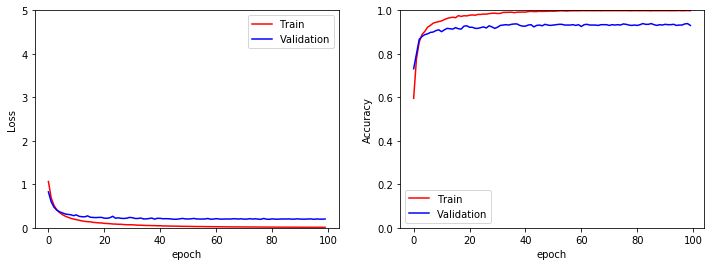

In [16]:
plot_results(res)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       1.00      0.96      0.98        55
         hex       1.00      1.00      1.00         4
       round       0.98      0.98      0.98       352
      square       0.92      0.94      0.93       130
    triangle       0.96      0.95      0.96       199

    accuracy                           0.97       740
   macro avg       0.97      0.97      0.97       740
weighted avg       0.97      0.97      0.97       740



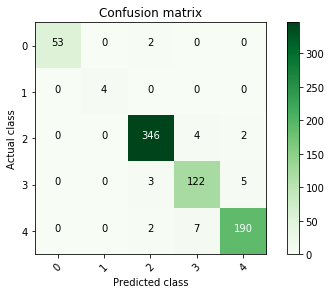

In [17]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_orig.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


# Using Regularization #



In [18]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy

# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
# reg for weight matrix 1
h = Dense(64,kernel_regularizer=regularizers.l2(0.01))(x)
h = Activation('sigmoid')(h)

# Output layer
# reg for weight matrix 2
out_ = Dense(5,kernel_regularizer=regularizers.l2(0.01))(h)
out_ = Activation('softmax')(out_)

# Define model
model_orig1 = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_orig1.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


model_orig1.summary()
# Creating a model for feature vizualization 
hidden_features = Model(inputs=input_, outputs=h)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_3 (Activation)    (None, 5)                 0   

In [19]:
#training the model1
res = train_model(model_orig1, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.1649246215820312, Accuracy = 0.5555742979049683
Validation epoch 0: Loss = 1.7559029637156307, Accuracy = 0.6368243098258972
Training epoch 1: Loss = 1.5063101053237915, Accuracy = 0.7241835594177246
Validation epoch 1: Loss = 1.3635923475832552, Accuracy = 0.6993243098258972
Training epoch 2: Loss = 1.2113323211669922, Accuracy = 0.7650337815284729
Validation epoch 2: Loss = 1.1252071599702578, Accuracy = 0.7550675868988037
Training epoch 3: Loss = 1.0595765113830566, Accuracy = 0.7890625
Validation epoch 3: Loss = 1.0060169696807861, Accuracy = 0.7989864945411682
Training epoch 4: Loss = 0.9730223417282104, Accuracy = 0.8135275840759277
Validation epoch 4: Loss = 0.9538247005359547, Accuracy = 0.8327702879905701
Training epoch 5: Loss = 0.9245871305465698, Accuracy = 0.8354870676994324
Validation epoch 5: Loss = 0.9283427402779862, Accuracy = 0.837837815284729
Training epoch 6: Loss = 0.9034532904624939, Accuracy = 0.8432714343070984
Validation epoch 6: Los

Training epoch 54: Loss = 0.8711333274841309, Accuracy = 0.864414393901825
Validation epoch 54: Loss = 0.8785427196605785, Accuracy = 0.8293918967247009
Training epoch 55: Loss = 0.8694466352462769, Accuracy = 0.8591075539588928
Validation epoch 55: Loss = 0.8705751283748729, Accuracy = 0.8868243098258972
Training epoch 56: Loss = 0.8697553277015686, Accuracy = 0.8677927851676941
Validation epoch 56: Loss = 0.9017609228958955, Accuracy = 0.787162184715271
Training epoch 57: Loss = 0.8749377131462097, Accuracy = 0.8574183583259583
Validation epoch 57: Loss = 0.8599950590649167, Accuracy = 0.8631756901741028
Training epoch 58: Loss = 0.8702379465103149, Accuracy = 0.8622747659683228
Validation epoch 58: Loss = 0.8731332163552981, Accuracy = 0.8648648858070374
Training epoch 59: Loss = 0.8671773672103882, Accuracy = 0.861190915107727
Validation epoch 59: Loss = 0.874492342407639, Accuracy = 0.8851351141929626
Training epoch 60: Loss = 0.8671689629554749, Accuracy = 0.8646255731582642
Vali

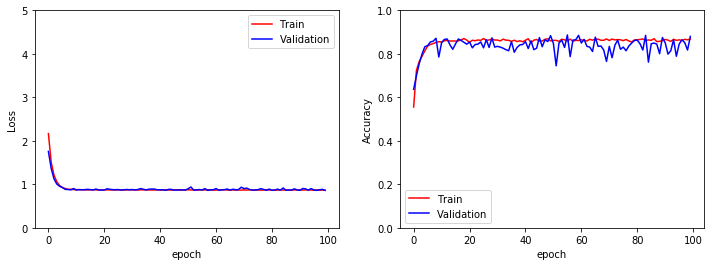

In [20]:
plot_results(res)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       0.92      0.64      0.75        55
         hex       0.00      0.00      0.00         4
       round       0.89      0.97      0.93       352
      square       0.88      0.86      0.87       130
    triangle       0.94      0.89      0.91       199

    accuracy                           0.90       740
   macro avg       0.73      0.67      0.69       740
weighted avg       0.90      0.90      0.90       740



/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


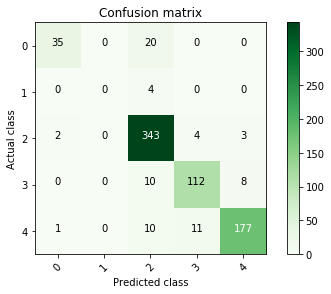

In [21]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_orig1.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))







## Extracting the hidden layer features

In [22]:
#print layer names
for layer in hidden_features.layers:
    print(layer.name)


def extract_hidden_features(model_, generator_, N_images): 
    batches = 0

    features = []
    inputs = []
    y_ = []

    # iterate over each batch
    for x,y in generator_:
        hf = model_.predict(x) 
        for h in hf:
            features.append(h)
        for yy in y:
            y_.append(np.argmax(yy))
        for xx in x:
            inputs.append(xx.reshape(-1,))

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 
    features = np.asarray(features)
    y = np.asarray(y_)
    inputs = np.asarray(inputs)
    
    return inputs, y, features



input_2
lambda_1
flatten_1
dense_2
activation_2


## Visualisation

Text(0.5, 1.0, 'Input Embedding')

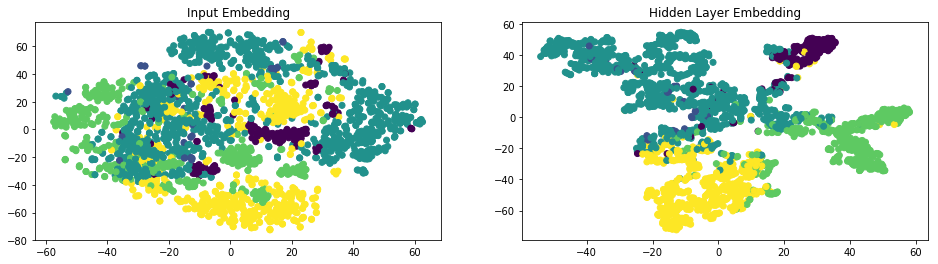

In [23]:
inputs, y, features = extract_hidden_features(hidden_features, train_generator, N_train_images)


from sklearn.manifold import TSNE

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

# Using Dropout#

In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy

# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64)(x)
h = Activation('sigmoid')(h)
h= Dropout(rate=0.5)(h)

# Output layer
out_ = Dense(5)(h)
out_ = Activation('softmax')(out_)

# Define model
model_orig2 = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_orig2.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_orig2.summary()
# Creating a model for feature vizualization 
hidden_features2 = Model(inputs=input_, outputs=h)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                50240     
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325 

In [25]:
#training the model12
res = train_model(model_orig2, num_epoch=100, verbose=1)

Training epoch 0: Loss = 1.2249629497528076, Accuracy = 0.5074042677879333
Validation epoch 0: Loss = 1.0012658625035673, Accuracy = 0.6233108043670654
Training epoch 1: Loss = 0.9676969647407532, Accuracy = 0.6412725448608398
Validation epoch 1: Loss = 0.7832969435163446, Accuracy = 0.7297297120094299
Training epoch 2: Loss = 0.8001405596733093, Accuracy = 0.7104026079177856
Validation epoch 2: Loss = 0.6621094418538583, Accuracy = 0.7533783912658691
Training epoch 3: Loss = 0.7068211436271667, Accuracy = 0.7465372085571289
Validation epoch 3: Loss = 0.5773403858010834, Accuracy = 0.8091216087341309
Training epoch 4: Loss = 0.6132754683494568, Accuracy = 0.7856278419494629
Validation epoch 4: Loss = 0.5061757677310222, Accuracy = 0.8327702879905701
Training epoch 5: Loss = 0.5476061701774597, Accuracy = 0.8079814314842224
Validation epoch 5: Loss = 0.4470846479808962, Accuracy = 0.8665540814399719
Training epoch 6: Loss = 0.5276024341583252, Accuracy = 0.826224684715271
Validation epo

Training epoch 54: Loss = 0.13210254907608032, Accuracy = 0.9514076709747314
Validation epoch 54: Loss = 0.1630760084434941, Accuracy = 0.9408783912658691
Training epoch 55: Loss = 0.13768136501312256, Accuracy = 0.9537584185600281
Validation epoch 55: Loss = 0.1573300774939157, Accuracy = 0.9476351141929626
Training epoch 56: Loss = 0.12714818120002747, Accuracy = 0.9548141956329346
Validation epoch 56: Loss = 0.15812775098743873, Accuracy = 0.9476351141929626
Training epoch 57: Loss = 0.12023957073688507, Accuracy = 0.9579814076423645
Validation epoch 57: Loss = 0.15911787715614648, Accuracy = 0.9391891956329346
Training epoch 58: Loss = 0.12539047002792358, Accuracy = 0.953125
Validation epoch 58: Loss = 0.1622637543273536, Accuracy = 0.9442567825317383
Training epoch 59: Loss = 0.11889316141605377, Accuracy = 0.9578970074653625
Validation epoch 59: Loss = 0.15587525641092578, Accuracy = 0.9408783912658691
Training epoch 60: Loss = 0.11073045432567596, Accuracy = 0.9641047120094299


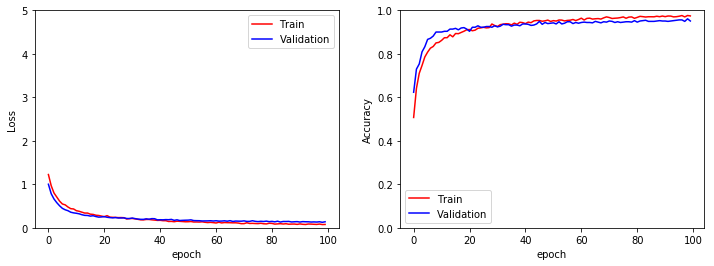

In [26]:
plot_results(res)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       0.98      0.91      0.94        55
         hex       1.00      1.00      1.00         4
       round       0.97      0.99      0.98       352
      square       0.97      0.93      0.95       130
    triangle       0.97      0.97      0.97       199

    accuracy                           0.97       740
   macro avg       0.98      0.96      0.97       740
weighted avg       0.97      0.97      0.97       740



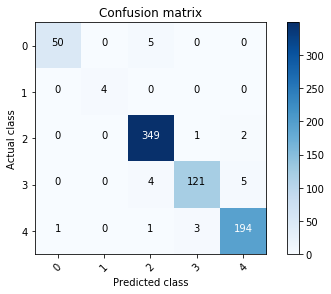

In [27]:
#  confusion matrix 
#Note, this code is taken straight from the SKLEARN website.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_orig2.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))

In [28]:
#print layer names
for layer in hidden_features2.layers:
    print(layer.name)


def extract_hidden_features(model_, generator_, N_images): 
    batches = 0

    features = []
    inputs = []
    y_ = []

    # iterate over each batch
    for x,y in generator_:
        hf = model_.predict(x) 
        for h in hf:
            features.append(h)
        for yy in y:
            y_.append(np.argmax(yy))
        for xx in x:
            inputs.append(xx.reshape(-1,))

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 
    features = np.asarray(features)
    y = np.asarray(y_)
    inputs = np.asarray(inputs)
    
    return inputs, y, features




input_3
lambda_2
flatten_2
dense_4
activation_4
dropout


Text(0.5, 1.0, 'Input Embedding')

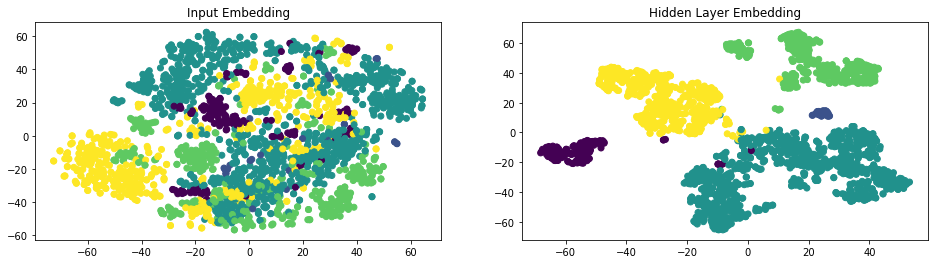

In [29]:
#Visualisation
inputs, y, features = extract_hidden_features(hidden_features2, train_generator, N_train_images)


from sklearn.manifold import TSNE

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

Text(0.5, 1.0, 'Input Embedding')

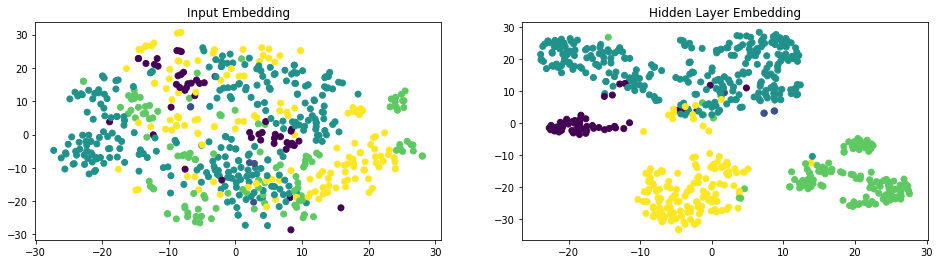

In [30]:
inputs, y, features = extract_hidden_features(hidden_features2, validation_generator, N_val_images)


from sklearn.manifold import TSNE

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

## Activation Function

sigmoid


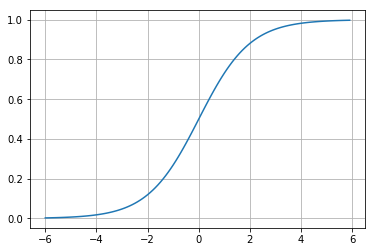

Tahn


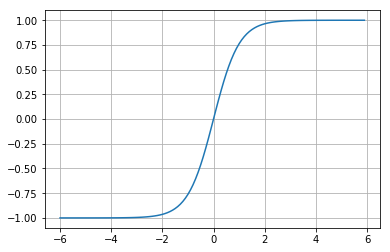

relu


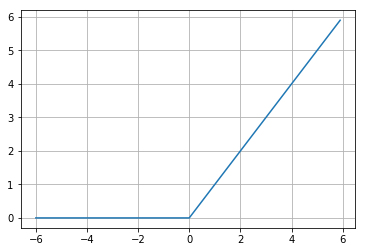

<Figure size 432x288 with 0 Axes>

In [31]:
import math
x = np.arange(-6, 6, 0.1)
#sigmoid
print("sigmoid")
def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

y = sigmoid(x)

plt.plot(x,y)
plt.grid()
plt.show()


#Tahn
print("Tahn")
def tanh(x, derivative=False):
    if (derivative == True):
        return (1 - (x ** 2))
    return np.tanh(x)


y = tanh(x)

plt.plot(x,y)
plt.grid()
plt.show()

#relu
print("relu")
def relu(x):
    a = []
    for item in x:
        if item > 0:
            a.append(item)
        else:
            a.append(0)
    return a


y = relu(x)

plt.plot(x,y)
plt.grid()
plt.show()

plt.tight_layout()

<h2> CNN Model <h2>

In [32]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn = Sequential()

# input
model_cnn.add(Input(shape=(28, 28, 3)))

model_cnn.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn.add(Conv2D(32, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
model_cnn.add(Conv2D(32, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))


# MLP
# MLP
model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
# model_cnn.save_weights('model.h5')

model_cnn.summary()
res = train_model(model_cnn, num_epoch=50, verbose=1)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation_6 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0

Training epoch 40: Loss = 0.006600026972591877, Accuracy = 0.9972550868988037
Validation epoch 40: Loss = 0.05641164751955396, Accuracy = 0.9864864945411682
Training epoch 41: Loss = 0.005097527988255024, Accuracy = 0.9978885054588318
Validation epoch 41: Loss = 0.06346898289747677, Accuracy = 0.9864864945411682
Training epoch 42: Loss = 0.017604505643248558, Accuracy = 0.9936655163764954
Validation epoch 42: Loss = 0.0809180486669071, Accuracy = 0.9898648858070374
Training epoch 43: Loss = 0.01067801471799612, Accuracy = 0.9968327879905701
Validation epoch 43: Loss = 0.07628354309111145, Accuracy = 0.9898648858070374
Training epoch 44: Loss = 0.0036230660043656826, Accuracy = 0.9995777010917664
Validation epoch 44: Loss = 0.07092582147137974, Accuracy = 0.9898648858070374
Training epoch 45: Loss = 0.009246069006621838, Accuracy = 0.9974662065505981
Validation epoch 45: Loss = 0.05695774250239851, Accuracy = 0.9881756901741028
Training epoch 46: Loss = 0.010235103778541088, Accuracy = 

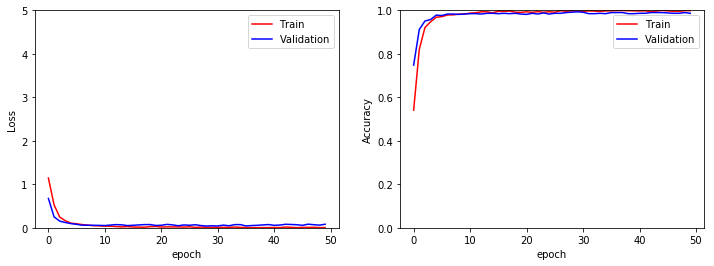

In [33]:
plot_results(res)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       1.00      1.00      1.00        55
         hex       0.80      1.00      0.89         4
       round       1.00      0.99      0.99       352
      square       1.00      0.97      0.98       130
    triangle       0.98      1.00      0.99       199

    accuracy                           0.99       740
   macro avg       0.95      0.99      0.97       740
weighted avg       0.99      0.99      0.99       740



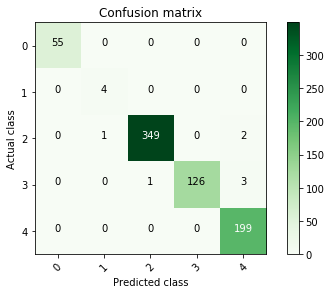

In [34]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_cnn.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))

In [35]:
#USING ELU ACTIVATION FUNCTION

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers


model_cnn4 = Sequential()

# input
model_cnn4.add(Input(shape=(28, 28, 3)))

model_cnn4.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn4.add(Conv2D(32, (3, 3)))
model_cnn4.add(Activation('elu'))
model_cnn4.add(MaxPooling2D(pool_size=(2, 2)))


# Conv Layer 2 
model_cnn4.add(Conv2D(32, (3, 3)))
model_cnn4.add(Activation('elu'))
model_cnn4.add(MaxPooling2D(pool_size=(2, 2)))



# MLP
model_cnn4.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn4.add(Dense(64))
model_cnn4.add(Activation('elu'))
model_cnn4.add(Dropout(0.5))
model_cnn4.add(Dense(5))
model_cnn4.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn4.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
model_cnn4.save_weights('model.h6')

model_cnn4.summary()
model_cnn4.load_weights('model.h6')
res = train_model(model_cnn4, num_epoch=50, verbose=1)




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_10 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)         

Training epoch 40: Loss = 77.23812103271484, Accuracy = 0.3310669958591461
Validation epoch 40: Loss = 68.94816455325565, Accuracy = 0.46452704071998596
Training epoch 41: Loss = 76.94517517089844, Accuracy = 0.3029279410839081
Validation epoch 41: Loss = 65.95727876714759, Accuracy = 0.24493242800235748
Training epoch 42: Loss = 75.89907836914062, Accuracy = 0.335951566696167
Validation epoch 42: Loss = 65.44167284063391, Accuracy = 0.46452704071998596
Training epoch 43: Loss = 72.84052276611328, Accuracy = 0.32428210973739624
Validation epoch 43: Loss = 63.164021633766794, Accuracy = 0.46452704071998596
Training epoch 44: Loss = 75.6663589477539, Accuracy = 0.31810247898101807
Validation epoch 44: Loss = 62.15371607767569, Accuracy = 0.46452704071998596
Training epoch 45: Loss = 68.85572052001953, Accuracy = 0.3324042558670044
Validation epoch 45: Loss = 60.548949112763275, Accuracy = 0.46452704071998596
Training epoch 46: Loss = 71.28804016113281, Accuracy = 0.3351351320743561
Valid

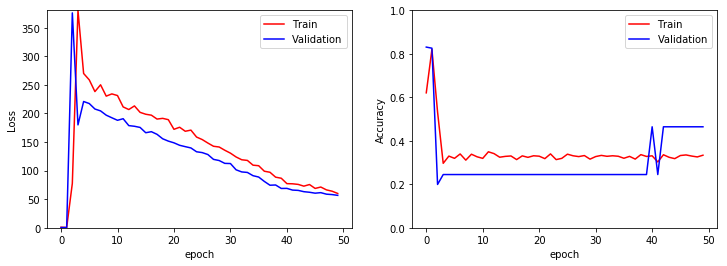

In [36]:
plot_results(res)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       0.00      0.00      0.00        55
         hex       0.00      0.00      0.00         4
       round       0.48      1.00      0.64       352
      square       0.00      0.00      0.00       130
    triangle       0.00      0.00      0.00       199

    accuracy                           0.48       740
   macro avg       0.10      0.20      0.13       740
weighted avg       0.23      0.48      0.31       740



/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


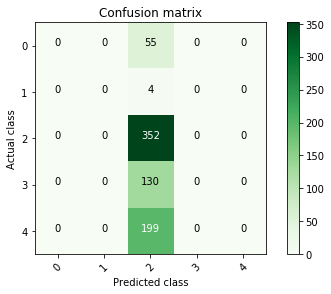

In [37]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_cnn4.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_14 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_15 (Activation)   (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)         

Training epoch 40: Loss = 0.0033874588552862406, Accuracy = 0.9991554021835327
Validation epoch 40: Loss = 0.05384019902206205, Accuracy = 0.9898648858070374
Training epoch 41: Loss = 0.009491106495261192, Accuracy = 0.9970439076423645
Validation epoch 41: Loss = 0.07082013725395016, Accuracy = 0.9881756901741028
Training epoch 42: Loss = 0.008284470066428185, Accuracy = 0.9970439076423645
Validation epoch 42: Loss = 0.04569830720808776, Accuracy = 0.9881756901741028
Training epoch 43: Loss = 0.010228949598968029, Accuracy = 0.9966216087341309
Validation epoch 43: Loss = 0.04833502695338308, Accuracy = 0.9881756901741028
Training epoch 44: Loss = 0.004828599747270346, Accuracy = 0.998099684715271
Validation epoch 44: Loss = 0.03827770090079971, Accuracy = 0.9881756901741028
Training epoch 45: Loss = 0.0024986891075968742, Accuracy = 0.9995777010917664
Validation epoch 45: Loss = 0.04381744426978909, Accuracy = 0.9898648858070374
Training epoch 46: Loss = 0.004534028470516205, Accuracy 

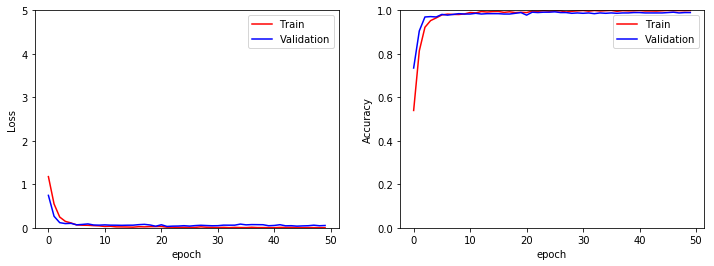

In [38]:
# Conv Layer 2 with  64 convolutional kernals value.
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn1 = Sequential()

# input
model_cnn1.add(Input(shape=(28, 28, 3)))

model_cnn1.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn1.add(Conv2D(32, (3, 3)))
model_cnn1.add(Activation('relu'))
model_cnn1.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
model_cnn1.add(Conv2D(64, (3, 3)))
model_cnn1.add(Activation('relu'))
model_cnn1.add(MaxPooling2D(pool_size=(2, 2)))



# MLP
model_cnn1.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn1.add(Dense(64))
model_cnn1.add(Activation('relu'))
model_cnn1.add(Dropout(0.5))
model_cnn1.add(Dense(5))
model_cnn1.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn1.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
# model_cnn.save_weights('model.h5')

model_cnn1.summary()
res = train_model(model_cnn1, num_epoch=50, verbose=1)

plot_results(res)

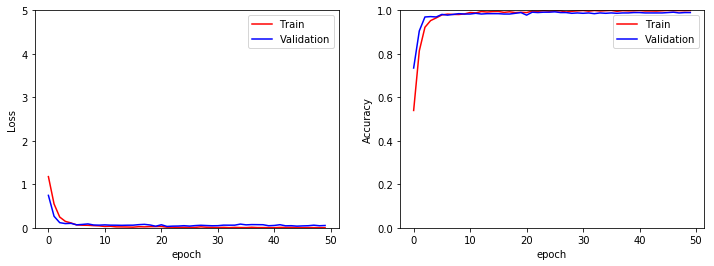

In [39]:
plot_results(res)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       0.98      1.00      0.99        55
         hex       0.80      1.00      0.89         4
       round       1.00      0.99      0.99       352
      square       1.00      0.99      1.00       130
    triangle       0.99      1.00      1.00       199

    accuracy                           0.99       740
   macro avg       0.95      1.00      0.97       740
weighted avg       0.99      0.99      0.99       740



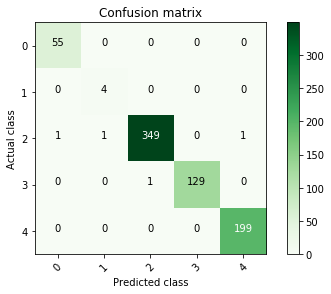

In [40]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_cnn1.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))

In [41]:
#CNN Model with 3 layers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn2 = Sequential()

# input
model_cnn2.add(Input(shape=(28, 28, 3)))

model_cnn2.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn2.add(Conv2D(32, (3, 3)))
model_cnn2.add(Activation('relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
model_cnn2.add(Conv2D(64, (3, 3)))
model_cnn2.add(Activation('relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3
model_cnn2.add(Conv2D(32, (3, 3)))
model_cnn2.add(Activation('relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))


# MLP
# MLP
model_cnn2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn2.add(Dense(64))
model_cnn2.add(Activation('relu'))
model_cnn2.add(Dropout(0.5))
model_cnn2.add(Dense(5))
model_cnn2.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn2.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations

model_cnn2.save_weights('model.h5')

model_cnn2.summary()
model_cnn2.load_weights('model.h5')
res = train_model(model_cnn2, num_epoch=50, verbose=1)



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_18 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_19 (Activation)   (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)         

Training epoch 37: Loss = 0.0025224697310477495, Accuracy = 0.9985219836235046
Validation epoch 37: Loss = 0.03001248190525519, Accuracy = 0.9949324131011963
Training epoch 38: Loss = 0.0009238598286174238, Accuracy = 1.0
Validation epoch 38: Loss = 0.02822555800409491, Accuracy = 0.9915540814399719
Training epoch 39: Loss = 0.0014849097933620214, Accuracy = 0.9995777010917664
Validation epoch 39: Loss = 0.034762596690169324, Accuracy = 0.9915540814399719
Training epoch 40: Loss = 0.0016376909334212542, Accuracy = 0.9995777010917664
Validation epoch 40: Loss = 0.03737502734085903, Accuracy = 0.9932432174682617
Training epoch 41: Loss = 0.0006389824557118118, Accuracy = 1.0
Validation epoch 41: Loss = 0.03524275700008116, Accuracy = 0.9932432174682617
Training epoch 42: Loss = 0.0018300397787243128, Accuracy = 0.9995777010917664
Validation epoch 42: Loss = 0.025496861755140064, Accuracy = 0.9932432174682617
Training epoch 43: Loss = 0.004078580532222986, Accuracy = 0.9983108043670654
Va

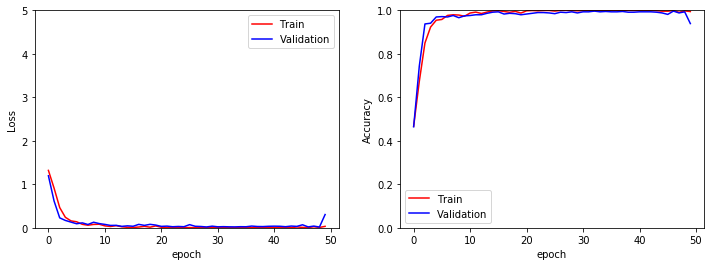

In [42]:
plot_results(res)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       0.96      0.98      0.97        55
         hex       0.80      1.00      0.89         4
       round       0.95      1.00      0.98       352
      square       0.95      0.97      0.96       130
    triangle       0.99      0.88      0.94       199

    accuracy                           0.96       740
   macro avg       0.93      0.97      0.95       740
weighted avg       0.96      0.96      0.96       740



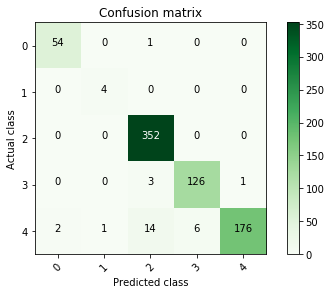

In [43]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_cnn2.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))

In [44]:
#model with 5x5 filter size
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn3 = Sequential()

# input
model_cnn3.add(Input(shape=(28, 28, 3)))

model_cnn3.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn3.add(Conv2D(32, (5, 5)))
model_cnn3.add(Activation('relu'))
model_cnn3.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
model_cnn3.add(Conv2D(64, (3, 3)))
model_cnn3.add(Activation('relu'))
model_cnn3.add(MaxPooling2D(pool_size=(2, 2)))


# MLP
model_cnn3.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn3.add(Dense(64))
model_cnn3.add(Activation('relu'))
model_cnn3.add(Dropout(0.5))
model_cnn3.add(Dense(5))
model_cnn3.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn3.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
model_cnn3.save_weights('model.h6')

model_cnn3.summary()
model_cnn3.load_weights('model.h6')
res = train_model(model_cnn3, num_epoch=100, verbose=1)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
activation_23 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_24 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 64)         

Training epoch 40: Loss = 0.004769924562424421, Accuracy = 0.9987331032752991
Validation epoch 40: Loss = 0.07459266807445727, Accuracy = 0.9831081032752991
Training epoch 41: Loss = 0.014614791609346867, Accuracy = 0.9949324131011963
Validation epoch 41: Loss = 0.029921766658514412, Accuracy = 0.9898648858070374
Training epoch 42: Loss = 0.0054920511320233345, Accuracy = 0.9978885054588318
Validation epoch 42: Loss = 0.034812804194818574, Accuracy = 0.9881756901741028
Training epoch 43: Loss = 0.0023123864084482193, Accuracy = 1.0
Validation epoch 43: Loss = 0.03687589875252876, Accuracy = 0.9898648858070374
Training epoch 44: Loss = 0.007628185674548149, Accuracy = 0.9982826709747314
Validation epoch 44: Loss = 0.03594186516734548, Accuracy = 0.9915540814399719
Training epoch 45: Loss = 0.00697373878210783, Accuracy = 0.9974662065505981
Validation epoch 45: Loss = 0.04403070348780679, Accuracy = 0.9847972989082336
Training epoch 46: Loss = 0.006575768813490868, Accuracy = 0.997255086

Training epoch 93: Loss = 0.001411035074852407, Accuracy = 0.9995777010917664
Validation epoch 93: Loss = 0.031033199417564477, Accuracy = 0.9915540814399719
Training epoch 94: Loss = 0.0010016125161200762, Accuracy = 1.0
Validation epoch 94: Loss = 0.029317799483421718, Accuracy = 0.9915540814399719
Training epoch 95: Loss = 0.0005730782868340611, Accuracy = 0.9997888803482056
Validation epoch 95: Loss = 0.04287473882717079, Accuracy = 0.9881756901741028
Training epoch 96: Loss = 0.002595404628664255, Accuracy = 0.9991554021835327
Validation epoch 96: Loss = 0.04073096549874059, Accuracy = 0.9864864945411682
Training epoch 97: Loss = 0.001922237453982234, Accuracy = 0.9995777010917664
Validation epoch 97: Loss = 0.036840718633524436, Accuracy = 0.9881756901741028
Training epoch 98: Loss = 0.0036275587044656277, Accuracy = 0.9983108043670654
Validation epoch 98: Loss = 0.045444861683754986, Accuracy = 0.9831081032752991
Training epoch 99: Loss = 0.0020397172775119543, Accuracy = 0.9995

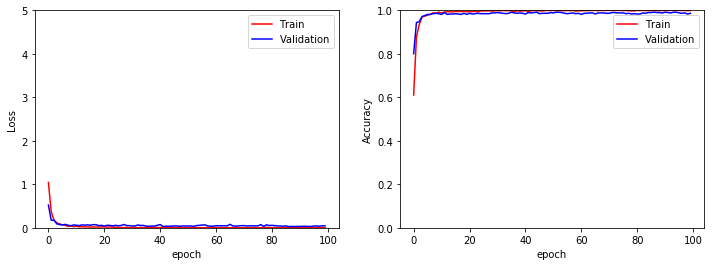

In [45]:
plot_results(res)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       0.96      0.98      0.97        55
         hex       0.80      1.00      0.89         4
       round       0.95      1.00      0.98       352
      square       0.95      0.97      0.96       130
    triangle       0.99      0.88      0.94       199

    accuracy                           0.96       740
   macro avg       0.93      0.97      0.95       740
weighted avg       0.96      0.96      0.96       740



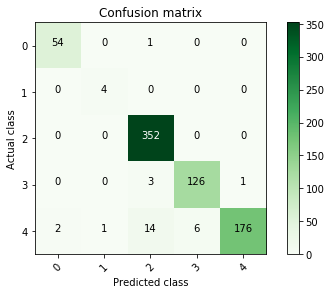

In [46]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_cnn2.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))

## Independent Evaluation

In [47]:
#upload and unzip data file
import zipfile
with zipfile.ZipFile('./indp_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [49]:
import cv2
import os

for filepath in glob.glob('indp_data/*/*/*.png', recursive=True):
    
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(gray, (28,28) , interpolation = cv2.INTER_AREA)
    img_resized.view
    cv2.imwrite(os.path.join(filepath), img_resized)

In [50]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('indp_data/*/*/*.png', recursive=True): #assuming gif
    shape = filepath.split("/")[1]
    signtype = filepath.split("/")[2]
    image_list.append((filepath, signtype, shape))
    
# Create a data frame
shape_data_test = pd.DataFrame(data=image_list, columns=['image_path', 'signtype', 'shape'])

In [51]:
shape_data_test.head()

,image_path,signtype,shape
0,indp_data/diamond/rightofway/traffic-sign-4087...,rightofway,diamond
1,indp_data/diamond/rightofway/main-road-right-o...,rightofway,diamond
2,indp_data/diamond/rightofway/images (1).png,rightofway,diamond
3,indp_data/diamond/rightofway/images.png,rightofway,diamond
4,indp_data/round/limitedtraffic/5.png,limitedtraffic,round


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

independent_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16


independent_test_generator = independent_datagen.flow_from_dataframe(
        dataframe=shape_data_test,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        shuffle = False,
        batch_size=batch_size,
        class_mode='categorical')

Found 68 validated image filenames belonging to 5 classes.


Prediction : (68, 5)
              precision    recall  f1-score   support

     diamond       0.50      0.50      0.50         4
         hex       1.00      0.80      0.89         5
       round       0.86      0.91      0.88        33
      square       1.00      0.59      0.74        17
    triangle       0.60      1.00      0.75         9

    accuracy                           0.81        68
   macro avg       0.79      0.76      0.75        68
weighted avg       0.85      0.81      0.81        68



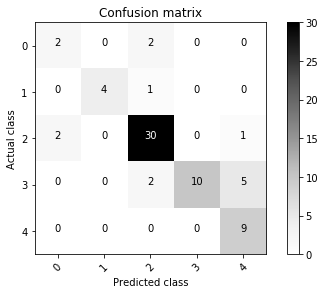

In [54]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools


prediction = model_cnn.predict_generator(independent_test_generator,verbose=0)
print("Prediction :", prediction.shape)

predictName =[]
for i in range(0,len(prediction[:,0])):
    predictName.append(np.argmax(prediction[i]))


true_classes = independent_test_generator.classes
class_labels = list(independent_test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictName, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictName)
plot_confusion_matrix(confusion_mtx, classes = range(5))




